## 19.
The above suggest that to prevent arbitrages the perpetual and perpetual inverse
exchange rates on a currency pair should both be equal to the spot exchange rate,
at least if the exchange uses an appropriate specification of the interest rate parts ($ξ$, $ξ_i$) of the funding rate. Use the data in DataSample.csv and a statistical method of your choice to confirm or infirm these relations for the currency pairs BTC/\\$ and ETH/\\$. In case of failure propose and implement a trading strategy designed to
benefit from the discrepancy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu, shapiro, ttest_ind, ttest_1samp


### Data and descriptive statistics

In [2]:
dataset = pd.read_csv("DataSample.csv")

In [3]:
# creation of new datasets to measure differences between rates
dataset["btc_lin_diff"] = dataset["BTC/USD (Exchange rate)"] - dataset["BTC/USD:USD (Linear)"]
dataset["btc_inv_diff"] = dataset["BTC/USD (Exchange rate)"] - dataset["BTC/USD:BTC (Inverse)"]
dataset["eth_lin_diff"] = dataset["ETH/USD (Exchange rate)"] - dataset["ETH/USD:USD (Linear)"]
dataset["eth_inv_diff"] = dataset["ETH/USD (Exchange rate)"] - dataset["ETH/USD:ETH (Inverse)"]

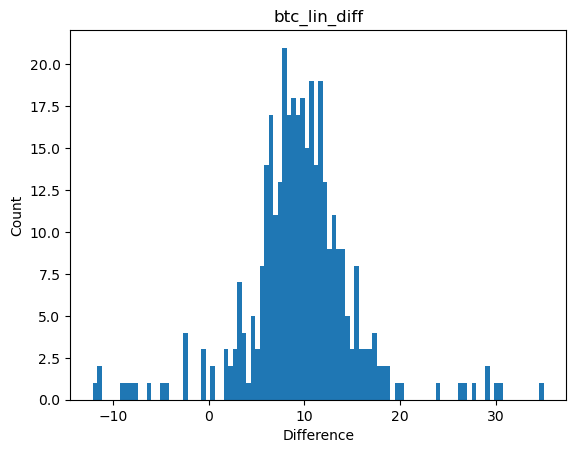

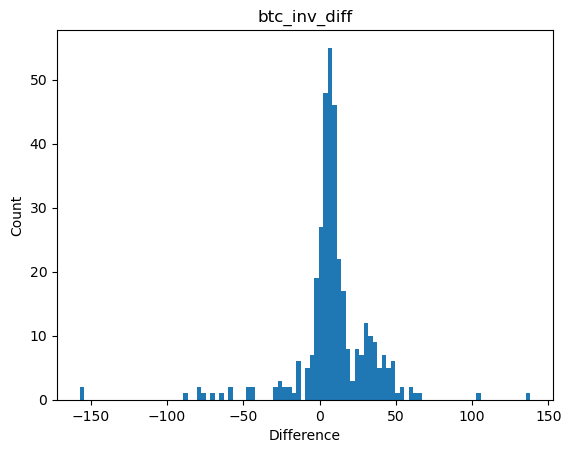

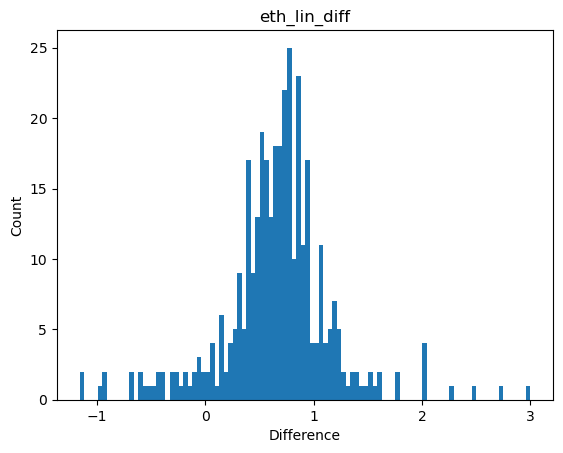

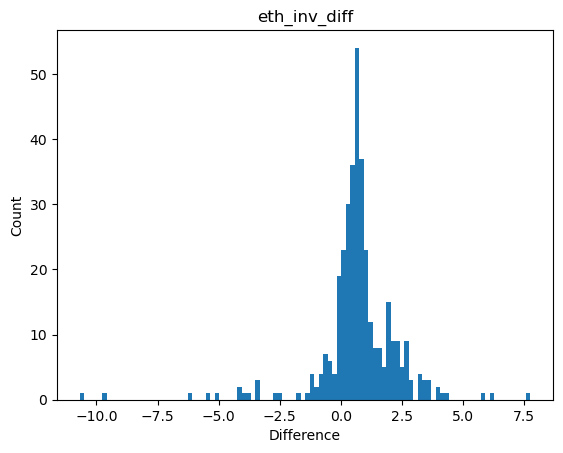

In [4]:
diffs = ["btc_lin_diff", "btc_inv_diff", "eth_lin_diff", "eth_inv_diff"]
for d in diffs:
    plt.hist(dataset[d], bins=100)
    plt.xlabel("Difference")
    plt.ylabel("Count")
    plt.title(d)
    plt.show()

In [5]:
dataset.describe()

,BTC/USD (Exchange rate),ETH/USD (Exchange rate),BTC/USD:USD (Linear),ETH/USD:USD (Linear),BTC/USD:BTC (Inverse),ETH/USD:ETH (Inverse),btc_lin_diff,btc_inv_diff,eth_lin_diff,eth_inv_diff
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,23036.009452,1597.001973,23026.449589,1596.344986,23026.866849,1596.292493,9.559863,9.142603,0.656986,0.709479
std,5682.530963,417.119279,5680.235889,416.929815,5681.580649,417.123565,5.757719,25.603336,0.514503,1.643562
min,15781.290000,995.130000,15773.000000,994.090000,15755.600000,993.070000,-12.090000,-157.370000,-1.160000,-10.690000
25%,19319.770000,1282.570000,19309.300000,1282.200000,19301.900000,1282.090000,6.940000,2.590000,0.450000,0.240000
50%,21515.610000,1566.100000,21505.600000,1565.840000,21506.100000,1565.480000,9.560000,7.610000,0.700000,0.640000
75%,24631.950000,1749.570000,24636.900000,1748.770000,24657.200000,1750.870000,12.110000,16.770000,0.880000,1.240000
max,41493.180000,3101.770000,41472.900000,3100.420000,41482.200000,3100.920000,34.980000,138.340000,3.000000,7.760000


In order to work with the dataset, we first created new datasets describing the differences between the spot rates and the linear/inverse rates for each currency in order to compare them in an easier way. From plotting these, we already get an insight that the relations might be infirmed.

### Tests

For all our tests, we use a 5\% significance level.

In [6]:
alpha = 0.05

We start by using the Mann-Whitney U test, which compares the distributions of two independent groups. If the p-value is below the significance level, we reject the null hypothesis, stating that the distributions are similar. As the test is non-parametric, we do not need to make assumptions about the distributions being normal.

Even though having similar distributions is not enough to state that the rates are statistically similar, it will give us more insights.

In [7]:
btc = ["BTC/USD:USD (Linear)", "BTC/USD:BTC (Inverse)"]

eth = ["ETH/USD:USD (Linear)", "ETH/USD:ETH (Inverse)"]

spot = {"BTC/USD (Exchange rate)": btc, "ETH/USD (Exchange rate)": eth}

for s in spot.keys():
    for curr in spot[s]:
        stat_mwu, p_mwu = mannwhitneyu(dataset[s], dataset[curr])
        if p_mwu < alpha:
            print("The distributions of {} and {} are statistically different (p-value {:.3f}).".format(s, curr, p_mwu))
        else:
            print("The distributions of {} and {} are statistically similar (p-value {:.3f}).".format(s, curr, p_mwu))

The distributions of BTC/USD (Exchange rate) and BTC/USD:USD (Linear) are statistically similar (p-value 0.923).
The distributions of BTC/USD (Exchange rate) and BTC/USD:BTC (Inverse) are statistically similar (p-value 0.938).
The distributions of ETH/USD (Exchange rate) and ETH/USD:USD (Linear) are statistically similar (p-value 0.933).
The distributions of ETH/USD (Exchange rate) and ETH/USD:ETH (Inverse) are statistically similar (p-value 0.937).


From these tests, we then notice that even though the price differences of distributions do not follow a Gaussian distribution with mean 0, they are statistically similar according to the Mann-Whitney U test for both currencies.

Even though the distributions are not normal, we can use the two-sample t-test to test similarity of the means, since our dataset size of 365 is sufficient. The variances between the different rates for each currency (below) seem to be close enough for the test to be reliable.

In [8]:
for s in spot.keys():
    print(s + " variance: " + str(dataset[s].var()))
    for curr in spot[s]:
        print(curr + " variance: " + str(dataset[curr].var()))
    print("\n")

BTC/USD (Exchange rate) variance: 32291158.14689311
BTC/USD:USD (Linear) variance: 32265079.760089118
BTC/USD:BTC (Inverse) variance: 32280358.676343095


ETH/USD (Exchange rate) variance: 173988.49301972444
ETH/USD:USD (Linear) variance: 173830.47103056317
ETH/USD:ETH (Inverse) variance: 173992.06832426132




In [9]:
for s in spot.keys():
    for curr in spot[s]:
        stat_t, p_t = ttest_ind(dataset[s], dataset[curr])
        if p_t < alpha:
            print("The means of {} and {} are statistically different (p-value {:.3f}).".format(s, curr, p_t))
        else:
            print("The means of {} and {} are statistically similar (p-value {:.3f}).".format(s, curr, p_t))

The means of BTC/USD (Exchange rate) and BTC/USD:USD (Linear) are statistically similar (p-value 0.982).
The means of BTC/USD (Exchange rate) and BTC/USD:BTC (Inverse) are statistically similar (p-value 0.983).
The means of ETH/USD (Exchange rate) and ETH/USD:USD (Linear) are statistically similar (p-value 0.983).
The means of ETH/USD (Exchange rate) and ETH/USD:ETH (Inverse) are statistically similar (p-value 0.982).


From the tests above, we can infer that the rate distributions are statistically similar. However, in order to actually be able to use the potential rate difference in a trading strategy, we need to study the differences better.

In practice, the prices will obviously not be equal over a longer period, however, we would expect the differences to follow a Gaussian distribution (with mean 0), in which case we could consider the deviations as noise.

From observing the means and the variances of each difference dataset, we see that the BTC differences seem further away from 0 than the ETH ones, however, this could be due to the prices of those two currencies, BTC trading way higher.

We use a Shapiro-Wilk test in order to either statistically confirm or infirm the zero-mean Gaussian distribution assumption.

In [10]:
for d in diffs:
    stat_sh, p_sh = shapiro(dataset[d])
    if p_sh < alpha:
        print("The distribution of {} is not Gaussian with mean 0.".format(d))
    else:
        print("The distribution of {} is Gaussian with mean 0.".format(d))

The distribution of btc_lin_diff is not Gaussian with mean 0.
The distribution of btc_inv_diff is not Gaussian with mean 0.
The distribution of eth_lin_diff is not Gaussian with mean 0.
The distribution of eth_inv_diff is not Gaussian with mean 0.


We see that the distribution of the price differences are not Gaussian with mean 0, which leads us to believe that the rates themselves might not be statistically similar.

However, to infer that, we test whether the distributions even have a mean at 0. If not, this would lead us even further, by allowing us to state that the rate datasets are significally different and hence not equal.

For this, we use the 1-sample t-test, comparing its mean to 0.

In [11]:
for d in diffs:
    stat_1, p_1 = ttest_1samp(dataset[d], 0)
    if p_1 < alpha:
        print("The mean of {} is statistically different from 0 (p-value {:.3f}).".format(d, p_1))
    else:
        print("The means of {} is statistically similar to 0 (p-value {:.3f}).".format(d, p_1))



The mean of btc_lin_diff is statistically different from 0 (p-value 0.000).
The mean of btc_inv_diff is statistically different from 0 (p-value 0.000).
The mean of eth_lin_diff is statistically different from 0 (p-value 0.000).
The mean of eth_inv_diff is statistically different from 0 (p-value 0.000).


This allows us to see that the interest rate component of the funding rate seems to be misspecified by the exchange, as the spot and futures rates are not equal.

### Strategy

Now that we have discovered that the rate differences do not have a mean of 0 (for all currency pairs and products), we can use this for our advantage.

As the spot rates are higher than both the linear and inverse rates for both currencies on average, we could thus construct a simple strategy based on this fact.

It consists in selling the concerned currency (BTC or ETH in our case) while simultaneously buying it back at the perpetual futures rate (linear or inverse, both work, but the linear difference is larger for BTC, whereas for ETH, the larger difference is with the inverse rate). As it is a zero-cost investment (as we buy and sell the same amount) as well as since it provides a positive expected payout, this strategy represents an arbitrage opportunity.

The trade needs to be carefully monitored, as even though on average, the spot rate is larger than the perpetual futures rates, it might not always be the case and thus we need to find the optimal time window to execute it. Also, due to trading fees, we should previously calculate whether the additional fees make the trade worth it.